## 🚀 XGBoost Classifier Notebook

This notebook build and evaluate an XGBoost classifier step-by-step.

### ⚙️ Configuration

#### 🔧 Overview

Setting up libraries and global settings to ensure smooth execution.

- 📦 Import essential libraries: xgboost, pandas, numpy, and sklearn.
- 🎲 Set a random seed for reproducibility.
- 💻 GPU set up for tensorflow.

In [ ]:
import numpy as np
import tensorflow as tf

2024-11-25 10:15:19.537593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 10:15:19.694216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732551319.753291    4370 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732551319.768742    4370 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 10:15:19.910957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Setting a random seed for consistent results.


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## 📂 Data Loader

### 🔍 Data Exploration and Preparation

1. Load the dataset into a pandas DataFrame.
2. Preprocess data:
    - 🧹 Handle missing values.
    - 🔄 Encode categorical variables.
    - 📏 Normalize numerical features if necessary.
3. Split the dataset: divide data into training and testing sets (80% training, 20% testing).

In [ ]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
class DataLoader:
    """
    Data loader for the cow count dataset

    Attributes:
        data_root (str): Root directory containing numbered folders (0-12 cows)
        expected_dirs (set): Set of expected directories
    """

    def __init__(self, data_root: str):
        """
        Initialize DataLoader ensuring coverage of all directories 0-12

        Args:
            data_root: Root directory containing numbered folders (0-12 cows)
        """
        self.data_root = Path(data_root)
        self.expected_dirs = set(str(i) for i in range(13))

    def verify_directories(self) -> set:
        """
        Verify all expected directories exist and report missing ones

        Returns:
            Set of existing directories
        """
        existing_dirs = set(
            d.name for d in self.data_root.glob("*") if d.is_dir() and d.name.isdigit()
        )

        missing_dirs = self.expected_dirs - existing_dirs
        extra_dirs = existing_dirs - self.expected_dirs

        if missing_dirs:
            print(
                f"Warning: Missing directories for cow counts: {sorted(missing_dirs)}"
            )

        if extra_dirs:
            print(f"Warning: Unexpected directories found: {sorted(extra_dirs)}")

        return existing_dirs

    def count_images_in_dir(self, dir_path: str) -> tuple:
        """
        Count the number of images in a directory and report unreadable images

        Args:
            dir_path (str): Path to directory containing images

        Returns:
            Tuple of total images and unreadable images
        """

        total = 0
        unreadable = 0

        for img_path in dir_path.glob("*jpg.rf.*"):
            total += 1
            try:
                tf.io.read_file(str(img_path))

            except tf.errors.InvalidArgumentError:
                unreadable += 1
                print(f"Warning: Unreadable image found: {img_path}")

        return total, unreadable

    def load_data(self) -> pd.DataFrame:
        """
        Loads data from the dataset into a DataFrame and provides summary statistics

        Returns:
            DataFrame containing image paths, cow counts, and timestamps
        """

        existing_dirs = self.verify_directories()
        if not existing_dirs:
            print("No directories found. Exiting.")
            return

        data = []
        for dir_name in sorted(self.expected_dirs):
            dir_path = self.data_root / dir_name

            if not dir_path.exists():
                print(f"Directory {dir_name} (cows) - Not found")
                continue

            total, unreadable = self.count_images_in_dir(dir_path)
            print(
                f"Directory {dir_name} (cows) - {total} images found, {unreadable} unreadable"
            )

            for img_path in dir_path.glob("*jpg.rf.*"):
                try:
                    timestamp_str = img_path.name.split("_jpg.rf")[0]
                    timestamp = pd.to_datetime(
                        timestamp_str, format="%Y-%m-%d-%H-%M-%S"
                    )

                    data.append(
                        {
                            "image_path": str(img_path),
                            "cow_count": int(dir_name),
                            "timestamp": timestamp,
                            "hour": timestamp.hour,
                        }
                    )
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

        df = pd.DataFrame(data)

        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="cow_count", order=range(13))
        plt.title("Distribution of Images by Cow Count")
        plt.xlabel("Number of Cows")
        plt.ylabel("Number of Images")
        plt.xticks(range(13))
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x="hour")
        plt.title("Distribution of Images by Hour")
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Images")
        plt.show()

        return df

In [ ]:
def verify_dataset(data_root: str) -> pd.DataFrame:
    """
    Auxiliary function to verify dataset completeness and quality
    of the given dataset.

    Args:
        data_root (str): Path to the dataset root directory

    Returns:
        pd.DataFrame: DataFrame containing image paths, cow counts, and timestamps
    """

    loader = DataLoader(data_root)
    df = loader.load_data()

    missing_counts = set(range(13)) - set(df["cow_count"].unique())
    if missing_counts:
        print(f"\nWarning: No images found for cow counts: {sorted(missing_counts)}")

    print("\nChecking for potential data quality issues...")

    df["time_diff"] = df["timestamp"].diff()
    large_gaps = df[df["time_diff"] > pd.Timedelta(hours=1)]
    if not large_gaps.empty:
        print(f"\nFound {len(large_gaps)} time gaps larger than 1 hour")
        print("Sample gaps:")
        print(large_gaps[["timestamp", "time_diff"]].head())

    missing_files = df[~df["image_path"].apply(lambda x: Path(x).exists())]
    if not missing_files.empty:
        print(f"\nWarning: {len(missing_files)} image files are missing")
        print("Sample missing files:")
        print(missing_files["image_path"].head())

    return df

## 🏗️ Model Creation

### 🛠️ Building the XGBoost Classifier

Define the model and its key parameters:

- 🔧 Learning Rate: 0.1
- 🌳 Max Depth: 6
- 🔢 Number of Estimators: 100

In [ ]:
import pickle
from pathlib import Path
from typing import List, Optional, Tuple

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from xgboost import XGBRegressor

/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class CowCounter:
    """
    Custom Cow Counter class designed to extract features and train using a
    Regressor from sklearn or XGBoost for cow counting.

    Attributes:
        img_size (Tuple[int, int]): Size of input images
        error_analysis (pd.DataFrame): DataFrame containing error analysis
        scaler (StandardScaler): StandardScaler object for feature scaling
        feature_extractor (tf.keras.Model): Pretrained ResNet50V2 model with attention
        training_history (dict): Dictionary containing training history metrics
        regressor (XGBRegressor or GradientBoostingRegressor): Regressor model for cow counting
    """

    def __init__(
        self, img_size: Tuple[int, int] = (224, 224), use_xgboost: bool = False
    ):
        self.img_size = img_size
        self.error_analysis = None
        self.scaler = StandardScaler()
        self.feature_extractor = self._build_resnet_model()
        self.training_history = {
            "timestamps": [],
            "exact_accuracy": [],
            "accuracy_within_one": [],
            "accuracy_within_two": [],
            "mse": [],
            "mae": [],
            "rmse": [],
            "num_training_images": [],
        }

    def _build_resnet_model(self) -> tf.keras.Model:
        """
        Build a ResNet50V2 model with attention mechanism
        for cow counting feature extraction

        Returns:
            tf.keras.Model: Pretrained ResNet50V2 model with attention
        """

        base_model = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=(*self.img_size, 3),
            pooling=None,
        )

        for layer in base_model.layers[:-70]:
            layer.trainable = False

        inputs = base_model.input
        x = base_model.output

        attention1 = tf.keras.layers.Conv2D(256, (1, 1))(x)
        attention1 = tf.keras.layers.BatchNormalization()(attention1)
        attention1 = tf.keras.layers.Activation("relu")(attention1)

        attention2 = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(attention1)
        attention2 = tf.keras.layers.BatchNormalization()(attention2)
        attention2 = tf.keras.layers.Activation("relu")(attention2)

        attention3 = tf.keras.layers.Conv2D(1, (1, 1))(attention2)
        attention = tf.keras.layers.Activation("sigmoid")(attention3)

        x = tf.keras.layers.Multiply()([x, attention])

        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
        max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
        x = tf.keras.layers.Concatenate()([avg_pool, max_pool])

        x = tf.keras.layers.Dense(1024, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)

        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        return tf.keras.Model(inputs=inputs, outputs=x)

    def _build_regressor(self, use_xgboost: bool = True):
        """
        Builds the selected regressor model for cow counting

        Args:
            use_xgboost (bool): Whether to use XGBoost or GradientBoostingRegressor
        """

        if use_xgboost:
            self.regressors = [
                XGBRegressor(
                    n_estimators=200,
                    learning_rate=0.03,
                    max_depth=6,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    tree_method="gpu_hist",
                    predictor="gpu_predictor",
                    objective="reg:squarederror",
                    n_jobs=-1,
                    random_state=i,
                    gamma=0.1,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    max_bin=256,
                )
                for i in range(7)
            ]

        else:
            from sklearn.ensemble import GradientBoostingRegressor

            self.regressors = [
                GradientBoostingRegressor(
                    n_estimators=400,
                    learning_rate=0.02,
                    max_depth=4,
                    min_samples_split=5,
                    subsample=0.85,
                    random_state=i,
                )
                for i in range(7)
            ]

    def preprocess_image(self, image_path: str, augment=True) -> np.ndarray:
        """
        Preprocess image for feature extraction and training with augmentation

        Args:
            image_path (str): Path to image file
            augment (bool): Whether to apply augmentation

        Returns:
            np.ndarray: Preprocessed image as numpy array

        Raises:
            ValueError: If image fails to load
            Exception: If any other error occurs during processing
        """

        try:
            img = cv2.imread(str(image_path))

            if img is None:
                raise ValueError(f"Failed to load image: {image_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

            if augment:
                if np.random.random() > 0.5:
                    img = img.astype(np.float32)
                    img = img * np.random.uniform(0.9, 1.1)

                if np.random.random() > 0.5:
                    mean = np.mean(img)
                    img = (img - mean) * np.random.uniform(0.9, 1.1) + mean

                if np.random.random() > 0.5:
                    img = cv2.flip(img, 1)

                if np.random.random() > 0.5:
                    angle = np.random.uniform(-5, 5)
                    height, width = img.shape[:2]
                    matrix = cv2.getRotationMatrix2D(
                        (width / 2, height / 2), angle, 1.0
                    )

                    img = cv2.warpAffine(img, matrix, (width, height))

            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
            img = (img.astype(np.float32) - 127.5) / 127.5

            return img

        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return np.zeros((*self.img_size, 3), dtype=np.float32)

    def extract_features(
        self, image_paths: List[str], batch_size: int = 32, augment: bool = True
    ) -> np.ndarray:
        """
        Extract features with multiple augmentations for each image during training.

        Args:
            image_paths (list): List of image paths
            batch_size (int): Batch size for feature extraction
            augment (bool): Whether to apply augmentation

        Returns:
            np.ndarray: Extracted features
        """
        features = []
        n_augmentations = 2 if augment else 1

        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i : i + batch_size]
            batch_features = []

            for _ in range(n_augmentations):
                batch_images = [
                    self.preprocess_image(path, augment=augment) for path in batch_paths
                ]

                batch_images = np.array(batch_images)

                with tf.device("/GPU:0"):
                    batch_output = self.feature_extractor.predict(
                        batch_images, verbose=0
                    )

                batch_features.append(batch_output)

            avg_features = np.mean(batch_features, axis=0)
            features.extend(avg_features)

        features = np.array(features)
        return (
            self.scaler.fit_transform(features)
            if augment
            else self.scaler.transform(features)
        )

    def train(
        self,
        train_images_paths: List[str],
        train_counts: List[int],
        batch_size: Optional[int] = 32,
        timestamp: Optional[datetime] = None,
    ):
        """
        Training method with historical metrics tracking.

        Args:
            train_images_paths (list): Path to training images
            train_counts (list): List of cow counts
            batch_size (int, optional): Batch size for training. Defaults
                                        to 32.
            timestamp (datetime, optional): Timestamp for this training run.
                                            If none, current time is used.
        """

        import datetime

        if timestamp is None:
            timestamp = datetime.datetime.now()

        print("Extracting features from training images...")
        X_train = self.extract_features(
            train_images_paths, batch_size=batch_size, augment=True
        )

        classes = np.unique(train_counts)
        class_weights = compute_class_weight(
            "balanced", classes=classes, y=train_counts
        )

        class_weights = np.sqrt(class_weights)
        class_weights = class_weights / np.sum(class_weights)
        weight_dict = dict(zip(classes, class_weights))
        sample_weights = np.array([weight_dict[y] for y in train_counts])

        predictions = []
        for i, regressor in enumerate(self.regressors):
            print(f"\nTraining model {i+1}/{len(self.regressors)}")
            try:
                regressor.fit(X_train, train_counts, sample_weight=sample_weights)
                pred = regressor.predict(X_train)
                predictions.append(pred)
            except Exception as e:
                print(f"Error training regressor {i+1}: {str(e)}")
                continue

        if not predictions:
            raise ValueError("No models were successfully trained")

        weights = []
        for pred in predictions:
            mae = mean_absolute_error(train_counts, pred)
            weights.append(1.0 / mae)
        weights = np.array(weights) / np.sum(weights)

        train_preds = np.average(predictions, axis=0, weights=weights)

        self.error_analysis = pd.DataFrame(
            {
                "true_count": train_counts,
                "predicted_count": train_preds,
                "error": train_preds - train_counts,
                "abs_error": np.abs(train_preds - train_counts),
            }
        )

        rounded_preds = np.round(train_preds)
        exact_accuracy = np.mean(rounded_preds == train_counts)
        within_one = np.mean(np.abs(rounded_preds - train_counts) <= 1)
        within_two = np.mean(np.abs(rounded_preds - train_counts) <= 2)

        self.training_history["timestamps"].append(timestamp)
        self.training_history["exact_accuracy"].append(exact_accuracy)
        self.training_history["accuracy_within_one"].append(within_one)
        self.training_history["accuracy_within_two"].append(within_two)
        self.training_history["mse"].append(
            mean_squared_error(train_counts, train_preds)
        )
        self.training_history["mae"].append(
            mean_absolute_error(train_counts, train_preds)
        )
        self.training_history["rmse"].append(np.sqrt(self.training_history["mse"][-1]))
        self.training_history["num_training_images"].append(len(train_counts))

    def get_training_history(self, metric: Optional[str] = None):
        """
        Retrieve training history metrics

        Args:
            metrics (str, optional): Specific metric to retrieve. If none,
                                     returns full history.

        Returns:
            dict or list: training history for all or specific metrics

        Raises:
            ValueError: If invalid metric is provided
        """

        if metric is None:
            return self.training_history

        if metric not in self.training_history:
            raise ValueError(f"Invalid metric: {metric}")

        return self.training_history[metric]

    def predict(self, image_paths, batch_size=32):
        """Predict using ensemble"""
        features = self.extract_features(
            image_paths,
            batch_size=batch_size,
            augment=False,
        )

        predictions = []
        for regressor in self.regressors:
            try:
                pred = regressor.predict(features)
                predictions.append(pred)
            except Exception as e:
                print(f"Error in prediction: {str(e)}")
                continue

        if not predictions:
            raise ValueError("No successful predictions")

        avg_predictions = np.mean(predictions, axis=0)
        return np.round(avg_predictions)

    def plot_training_history(self, metrics=None):
        """
        Plot training history metrics

        Args:
            metrics (list, optional): List of metrics to plot. If none, all
                                       metrics are plotted.
        """

        if metrics is None:
            metrics = [
                "exact_accuracy",
                "accuracy_within_one",
                "accuracy_within_two",
                "mse",
                "mae",
                "rmse",
            ]

        fig, axes = plt.subplots(
            len(metrics), 1, figsize=(10, 4 * len(metrics)), sharex=True
        )

        if len(metrics()) == 1:
            axes = [axes]

        for i, metric in enumerate(metrics):
            data = self.training_history[metric]
            timestamps = self.training_history["timestamps"]

            axes[i].plot(timestamps, data, marker="o")
            axes[i].set_title(f"Training History: {metric}")
            axes[i].set_ylabel(metric)

        plt.xlabel("Timestamp")
        plt.tight_layout()
        plt.show()

    def save_traininig_history(
        self, filepath: Optional[str] = "cow_counter_history.csv"
    ):
        """
        Save training history to CSV file

        Args:
            filepath (str, optional): Filepath to save training history.
                                       Defaults to 'cow_counter_history.csv'.

        Raises:
            ValueError: If invalid filepath is provided
        """

        if not filepath:
            raise ValueError("Invalid filepath")

        df = pd.DataFrame(self.training_history)
        df.to_csv(filepath, index=False)

    def load_training_history(
        self, filepath: Optional[str] = "cow_counter_history.csv"
    ):
        """
        Load training history from CSV file

        Args:
            filepath (str, optional): Filepath to load training history.
                                       Defaults to 'cow_counter_history.csv'.

        Raises:
            ValueError: If invalid filepath is provided
        """

        if not filepath:
            raise ValueError("Invalid filepath")

        df = pd.read_csv(filepath)
        self.training_history = df.to_dict(orient="list")

## 📊 Visualizations



In [ ]:
def plot_cow_distribution(data: pd.DataFrame):
    """
    Plots the cow distribution in the dataset (label distribution)

    Args:
        data (pd.DataFrame): DataFrame containing image paths, cow counts, and timestamps
    """

    plt.figure(figsize=(12, 6))

    sns.countplot(data=data, x="cow_count")
    plt.title("Distribution of Images by Cow Count")
    plt.xlabel("Number of Cows")
    plt.ylabel("Number of Images")
    plt.show()

In [ ]:
def plot_distribution_by_hour(data: pd.DataFrame):
    """
    Plots the distribution by hour in the dataset using the
    timestamp field of the dataframe.

    Args:
        data (pd.DataFrame): DataFrame containing image paths, cow counts, and timestamps
    """

    data_df = data.copy()
    data_df["hour"] = data_df["timestamp"].dt.hour

    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_df, x="hour")
    plt.title("Distribution of Images by Hour")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Images")
    plt.show()

In [ ]:
def plot_confusion_matrix(data: pd.DataFrame):
    """
    Plots the confusion matrix for the given data

    Args:
        data (pd.DataFrame): DataFrame containing true and predicted cow counts

    Raises:
        ImportError: If seaborn is not installed
    """

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(data["true_count"], data["predicted_count"])
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## Training Config


In [10]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
def train_cow_counter(
    data_root: str,
    output_dir: str = "cow_counter_output",
    img_size: tuple = (224, 224),
    batch_size: int = 32,
    use_xgboost: bool = True,
    test_size: float = 0.2,
    time_based_split: bool = True,
) -> Tuple[CowCounter, dict]:
    """
    Train function for the Cow Counter model. It builds the model, trains it
    on the given data, and evaluates it using the test set.

    Args:
        data_root (str): Path to the dataset root directory
        output_dir (str): Path to the output directory
        img_size (tuple): Size of input images
        batch_size (int): Batch size for training
        use_xgboost (bool): Whether to use XGBoost or GradientBoostingRegressor
        test_size (float): Size of the test set
        time_based_split (bool): Whether to split the data based on time

    Returns:
        CowCounter: Trained CowCounter model
        dict: Evaluation results
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    data_loader = DataLoader(data_root)
    data_df = data_loader.load_data()

    if time_based_split:
        split_time = data_df["timestamp"].quantile(1 - test_size)
        train_df = data_df[data_df["timestamp"] < split_time]
        test_df = data_df[data_df["timestamp"] >= split_time]

        X_train = train_df["image_path"].values
        y_train = train_df["cow_count"].values

        X_test = test_df["image_path"].values
        y_test = test_df["cow_count"].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data_df["image_path"].values,
            data_df["cow_count"].values,
            test_size,
            random_state=42,
            stratify=data_df["cow_count"].values,
        )

    model = CowCounter(img_size=img_size, use_xgboost=use_xgboost)
    model.train(X_train, y_train, batch_size=batch_size)

    predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)
    test_preds_rounded = np.round(predictions).astype(int)

    plot_confusion_matrix(
        pd.DataFrame({"true_count": y_test, "predicted_count": test_preds_rounded})
    )

    evaluation_results = {
        "test_mse": float(test_mse),
        "test_mae": float(test_mae),
        "test_rmse": float(np.sqrt(test_mse)),
        "num_training_samples": len(X_train),
        "num_test_samples": len(X_test),
        "image_size": img_size,
        "batch_size": batch_size,
        "use_xgboost": use_xgboost,
        "time_based_split": time_based_split,
        "f1-score": f1_score(y_test, test_preds_rounded, average="weighted"),
        "accuracy": accuracy_score(y_test, test_preds_rounded),
    }

    return model, evaluation_results

## Main Execution


### Hyperparams


In [13]:
DATA_ROOT = "../../../data/extended/day/"
OUTPUT_DIR = "cow_counter_output"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
USE_XGBOOST = True
TIME_BASED_SPLIT = True

### Execution


Verifying directory structure...

Counting images in each directory:


I0000 00:00:1732551326.322523    4370 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Directory 0 (cows) - 206 images found, 0 unreadable
Directory 1 (cows) - 385 images found, 0 unreadable
Directory 10 (cows) - 67 images found, 0 unreadable
Directory 11 (cows) - 37 images found, 0 unreadable
Directory 12 (cows) - 5 images found, 0 unreadable
Directory 2 (cows) - 543 images found, 0 unreadable
Directory 3 (cows) - 635 images found, 0 unreadable
Directory 4 (cows) - 584 images found, 0 unreadable
Directory 5 (cows) - 646 images found, 0 unreadable
Directory 6 (cows) - 522 images found, 0 unreadable
Directory 7 (cows) - 342 images found, 0 unreadable
Directory 8 (cows) - 241 images found, 0 unreadable
Directory 9 (cows) - 155 images found, 0 unreadable

Dataset Summary:
Total images found: 4368

Images per cow count:
cow_count
0     206
1     385
2     543
3     635
4     584
5     646
6     522
7     342
8     241
9     155
10     67
11     37
12      5
Name: count, dtype: int64


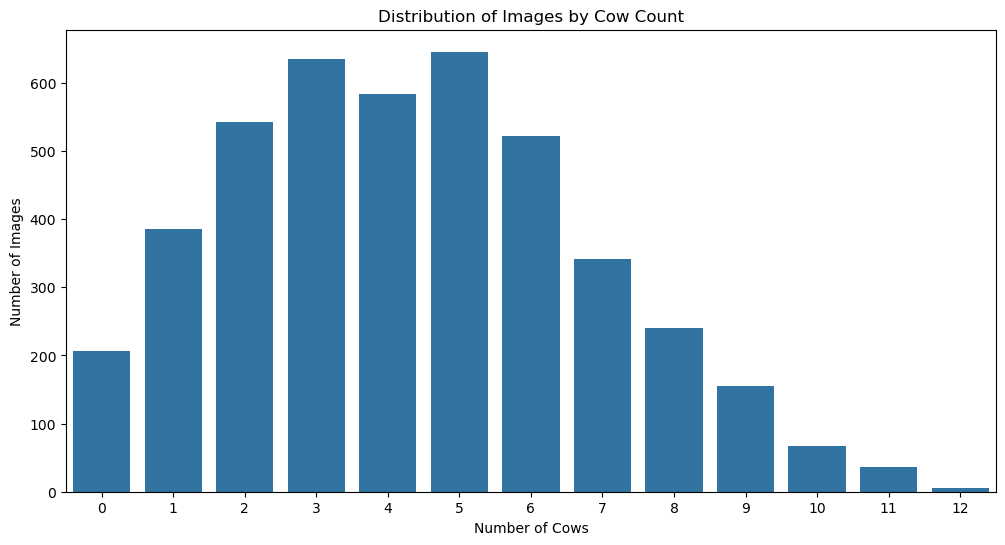

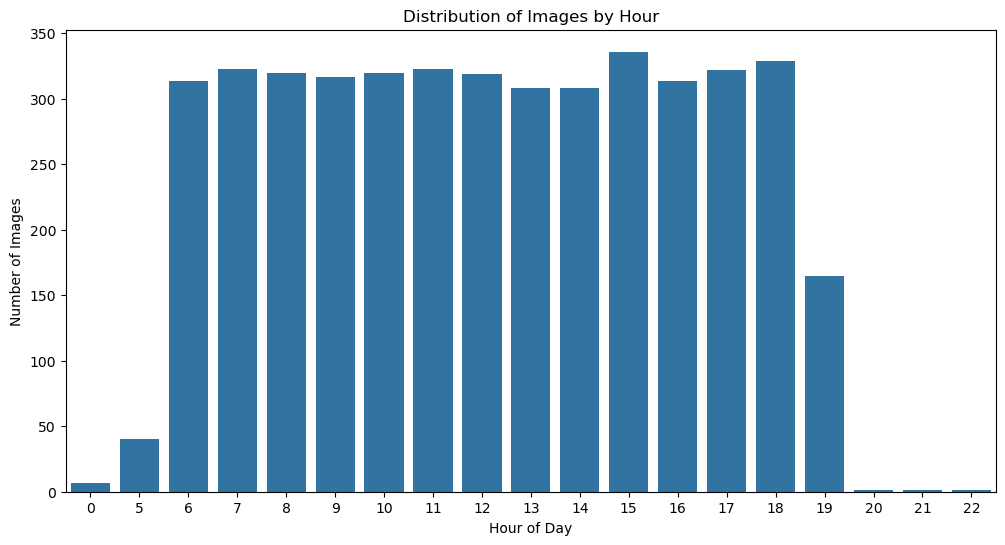

Extracting features from training images...


  0%|          | 0/219 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732551346.495647    8953 service.cc:148] XLA service 0x7f92f8010bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732551346.496140    8953 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-25 10:15:46.547397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732551346.852615    8953 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732551351.098051    8953 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
 35%|███▌      | 77/219 [40:23<1:12:09, 30.49s/it]

In [ ]:
model, results = train_cow_counter(
    data_root=DATA_ROOT,
    output_dir=OUTPUT_DIR,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    use_xgboost=USE_XGBOOST,
    time_based_split=TIME_BASED_SPLIT,
)

In [ ]:
print(f"Test MSE: {results['test_mse']:.4f}")
print(f"Test MAE: {results['test_mae']:.4f}")
print(f"Test RMSE: {results['test_rmse']:.4f}")
print(f"F1-score: {results['f1-score']:.4f}")
print(f"Accuracy: {results['accuracy']:.4f}")

Test MSE: 2.3387
Test MAE: 1.1648
Test RMSE: 1.5293
F1-score: 0.2595
Accuracy: 0.2723


## Training Metrics


In [ ]:
full_history = train_cow_counter.get_training_history()

In [ ]:
train_cow_counter.plot_training_history()